In [3]:
!pip uninstall -y keras
!pip install tf-keras


Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 8.5 MB/s eta 0:00:00
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)

   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   -----------

In [4]:
!pip install tensorflow hdbscan umap-learn scikit-learn pandas openpyxl sentence-transformers

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import hdbscan
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

### 📂 Step 1: Load Data

We load the required Excel files containing:
- PE firm details
- Company information
- Historical transactions


In [5]:
# === STEP 1: Load Data ===
pe_df = pd.read_excel("../newdata/Cleaned_PE.xlsx")
company_df = pd.read_excel("../newdata/outputcheckcombined.xlsx")
transactions_df = pd.read_excel("../newdata/PE_Transactions.xlsx")

### ✍️ Step 2: Text Normalization & Sector Embeddings

We clean and lowercase sector descriptions, then embed them using `SentenceTransformer` (SBERT) to capture semantic similarities.


In [6]:
# === STEP 2: Text Preprocessing & Sector Embedding ===
sbert = SentenceTransformer('all-MiniLM-L6-v2')

company_df['normalized_sectors'] = company_df['1º_characterization'].fillna('').str.lower()
pe_df['normalized_sectors'] = pe_df['Sectors'].fillna('').str.lower()

company_df['sector_embeddings'] = company_df['normalized_sectors'].apply(lambda x: sbert.encode(x))
pe_df['sector_embeddings'] = pe_df['normalized_sectors'].apply(lambda x: sbert.encode(x))


### 🔁 Step 3: Cross Join & Feature Engineering

We generate all possible PE-company combinations, then compute:
- Semantic **sector similarity**
- **EBITDA compatibility**
- PE firm’s **presence in Spain**


In [7]:
# === STEP 3: Cross Join & Feature Engineering ===
company_df['key'] = 1
pe_df['key'] = 1
pairs_df = company_df.merge(pe_df, on='key').drop('key', axis=1)


In [8]:
# Sector similarity score
pairs_df['sector_similarity_score'] = pairs_df.apply(
    lambda row: cosine_similarity(
        row['sector_embeddings_x'].reshape(1, -1),
        row['sector_embeddings_y'].reshape(1, -1)
    )[0][0], axis=1
)

In [9]:
# EBITDA compatibility
pairs_df['ebitda_in_range'] = pairs_df.apply(
    lambda row: row['ticket_ebitda_min'] <= row['ebitda_lya_m'] <= row['ticket_ebitda_max']
    if not pd.isnull(row['ebitda_lya_m']) else False, axis=1
)

In [10]:
# Final feature set
X = pairs_df[['sector_similarity_score', 'ebitda_in_range', 'Total Spanish Companies']]
X['ebitda_in_range'] = X['ebitda_in_range'].astype(int)
X.fillna(0, inplace=True)

C:\Users\Samir\AppData\Local\Temp\ipykernel_7108\2570384560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ebitda_in_range'] = X['ebitda_in_range'].astype(int)
C:\Users\Samir\AppData\Local\Temp\ipykernel_7108\2570384560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


### 🧠 Step 4: Autoencoder for Dimensionality Reduction

We compress our structured feature space using a simple neural autoencoder with 2D latent space.


In [11]:
# === STEP 4: Normalize & Autoencode ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(4, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, verbose=0)

X_encoded = encoder.predict(X_scaled)

9977/9977 ━━━━━━━━━━━━━━━━━━━━ 4s 440us/step


### 🧭 Step 5: HDBSCAN Clustering

We apply HDBSCAN to the 2D encoded data to uncover meaningful clusters among PE–company matches.


In [12]:
# === STEP 5: HDBSCAN on Encoded Features ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, prediction_data=True)
pairs_df['cluster'] = clusterer.fit_predict(X_encoded)


c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### 🌈 Step 6: UMAP Visualization

We use UMAP to project the 2D encoded data for better visualization of cluster structure.


c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


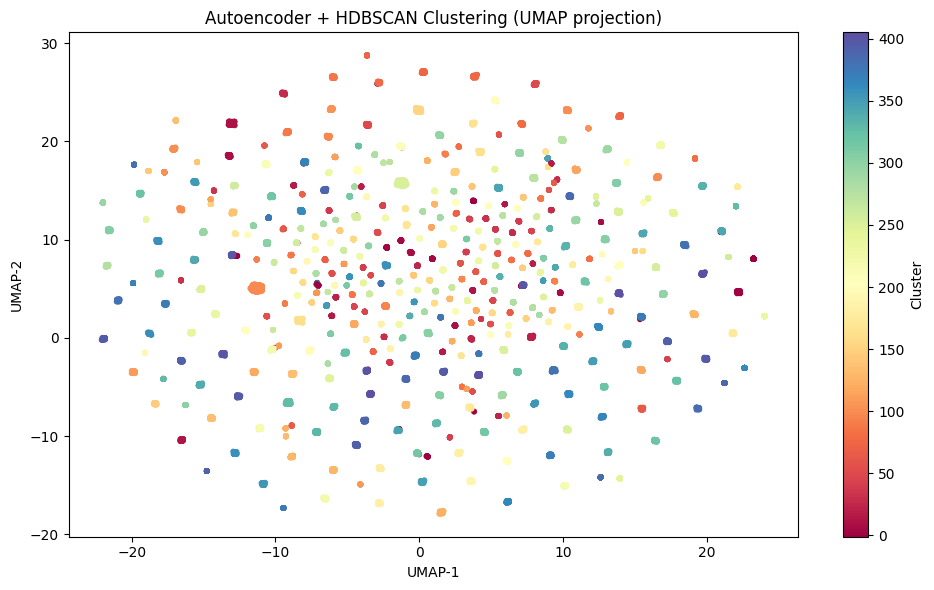

In [13]:
# === STEP 6: Visualize with UMAP ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_encoded)

plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=pairs_df['cluster'], cmap='Spectral', s=10)
plt.colorbar(label='Cluster')
plt.title('Autoencoder + HDBSCAN Clustering (UMAP projection)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()


### 🎯 Step 7: Precision@5 Evaluation

We test how often true historical PE–company matches appear in the top-5 clustered recommendations.


In [14]:
# === STEP 7: Precision@5 Evaluation ===
# Clean names
pairs_df['company_name_clean'] = pairs_df['company_name'].str.lower().str.strip()
pairs_df['pe_clean'] = pairs_df['PE'].str.lower().str.strip()
transactions_df['Target_clean'] = transactions_df['Target'].str.lower().str.strip()
transactions_df['PE_clean'] = transactions_df['PE'].str.lower().str.strip()

# Known matches
known_matches = set(zip(transactions_df['Target_clean'], transactions_df['PE_clean']))

# Group by company and evaluate top-5 PEs by cluster membership
grouped = pairs_df.groupby('company_name_clean')
precision_at_k = defaultdict(list)

for company_name, group in grouped:
    group = group.sort_values('cluster', ascending=True)  # naive ranking by cluster
    top_k_pe_clean = group['pe_clean'].head(5)

    is_match = any((company_name, pe) in known_matches for pe in top_k_pe_clean)
    precision_at_k[5].append(int(is_match))

# Final result
if precision_at_k[5]:
    p_at_5 = sum(precision_at_k[5]) / len(precision_at_k[5])
    print(f"Precision@5 (Autoencoder + HDBSCAN): {p_at_5:.4f}")
else:
    print("No valid company–PE pairs were evaluated for Precision@5.")

Precision@5 (Autoencoder + HDBSCAN): 0.0000


### 🧠 Refining Autoencoder + HDBSCAN with Structured Features

Previously, we tested an unsupervised learning pipeline using an autoencoder followed by HDBSCAN clustering, relying mostly on sector embeddings. However, the precision remained low. To strengthen our representation and better capture the economic logic of private equity (PE) targeting behavior, we now enrich our feature set with structured financial and geographic variables inspired by the supervised CatBoost model:

- **`sector_similarity_score`**: SBERT-based cosine similarity between the company's and PE firm's sectors.
- **`ebitda_in_range`**: A binary indicator showing whether the company's EBITDA lies within the PE's investment ticket range.
- **`Total Spanish Companies`**: A proxy for the PE's Spanish market involvement — adding local investment bias as a factor.

This enhanced feature space is expected to improve cluster formation and boost match precision, moving us closer to a hybrid architecture that leverages both semantic similarity and real-world financial compatibility.

We'll re-run the autoencoder with these features and apply HDBSCAN clustering again, followed by a new Precision@5 evaluation against known historical deals.


In [17]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import hdbscan
import umap.umap_ as umap
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [18]:
# === Feature Engineering (Expanded) ===
pairs_df['sector_similarity_score'] = pairs_df.apply(
    lambda row: cosine_similarity(
        row['sector_embeddings_x'].reshape(1, -1),
        row['sector_embeddings_y'].reshape(1, -1)
    )[0][0], axis=1
)

pairs_df['ebitda_in_range'] = pairs_df.apply(
    lambda row: row['ticket_ebitda_min'] <= row['ebitda_lya_m'] <= row['ticket_ebitda_max']
    if not pd.isnull(row['ebitda_lya_m']) else False, axis=1
)

X = pairs_df[['sector_similarity_score', 'ebitda_in_range', 'Total Spanish Companies']].copy()
X['ebitda_in_range'] = X['ebitda_in_range'].astype(int)
X.fillna(0, inplace=True)

In [19]:
# === Autoencoder Setup ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(4, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, verbose=0)

X_encoded = encoder.predict(X_scaled)

9977/9977 ━━━━━━━━━━━━━━━━━━━━ 4s 438us/step


c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


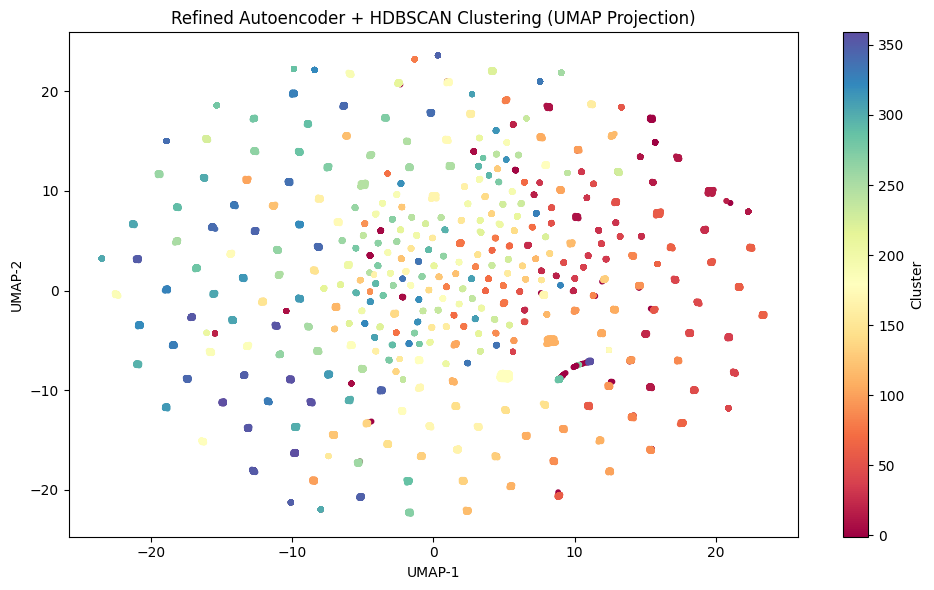

In [20]:
# === HDBSCAN Clustering ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, prediction_data=True)
pairs_df['cluster'] = clusterer.fit_predict(X_encoded)

# === UMAP Visualization ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_encoded)

plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=pairs_df['cluster'], cmap='Spectral', s=10)
plt.colorbar(label='Cluster')
plt.title('Refined Autoencoder + HDBSCAN Clustering (UMAP Projection)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()


In [21]:
# === Precision@5 Evaluation ===
pairs_df['company_name_clean'] = pairs_df['company_name'].str.lower().str.strip()
pairs_df['pe_clean'] = pairs_df['PE'].str.lower().str.strip()
transactions_df['Target_clean'] = transactions_df['Target'].str.lower().str.strip()
transactions_df['PE_clean'] = transactions_df['PE'].str.lower().str.strip()

known_matches = set(zip(transactions_df['Target_clean'], transactions_df['PE_clean']))

grouped = pairs_df.groupby('company_name_clean')
precision_at_k = defaultdict(list)

for company_name, group in grouped:
    group = group.sort_values('cluster', ascending=True)
    top_k_pe_clean = group['pe_clean'].head(5)

    is_match = any((company_name, pe) in known_matches for pe in top_k_pe_clean)
    precision_at_k[5].append(int(is_match))

if precision_at_k[5]:
    p_at_5 = sum(precision_at_k[5]) / len(precision_at_k[5])
    print(f"Precision@5 (Refined Autoencoder + HDBSCAN): {p_at_5:.4f}")
else:
    print("No valid company–PE pairs were evaluated for Precision@5.")

Precision@5 (Refined Autoencoder + HDBSCAN): 0.0000


In [22]:
import joblib

# Save StandardScaler used before autoencoder
joblib.dump(scaler, "refined_scaler.pkl")


['refined_scaler.pkl']

In [23]:
# Save only the encoder part of the autoencoder
encoder.save("refined_encoder_model.keras")
